In [1]:
from landsatxplore.api import API
import json
from landsatxplore.earthexplorer import EarthExplorer
import os
import pandas as pd
import glob
import tarfile
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import utm 
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show

username = "SimWen"
password = "..."

## 1. Find and save the data

Documentation here:
https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf

In [27]:
# Initialize a new API instance and get an access key
api = API(username, password)

# Search for Landsat TM scenes
scenes = api.search(
    dataset='landsat_ot_c2_l2',
    latitude=51.509,
    longitude=-0.126,
    start_date='2023-04-01',
    end_date='2023-10-01',
    max_cloud_cover=10
)

print(f"{len(scenes)} scenes found")

api.logout()

5 scenes found


In [28]:
# Process the result
for scene in scenes:
    print(scene['acquisition_date'].strftime('%Y-%m-%d'))
    # Write scene footprints to disk
    fname = f"{scene['landsat_product_id']}.geojson"
    with open(fname, "w") as f:
        json.dump(scene['spatial_coverage'].__geo_interface__, f)

2023-09-15
2023-09-07
2023-09-06
2023-08-05
2023-05-26


In [29]:
df_scenes = pd.DataFrame(scenes)
df_scenes = df_scenes[['display_id','wrs_path', 'wrs_row','satellite','cloud_cover','acquisition_date']]
df_scenes.sort_values('acquisition_date', ascending=False, inplace=True)
df_scenes

,display_id,wrs_path,wrs_row,satellite,cloud_cover,acquisition_date
0,LC08_L2SP_201024_20230915_20230925_02_T1,201,24,8,3,2023-09-15
1,LC09_L2SP_201024_20230907_20230913_02_T1,201,24,9,0,2023-09-07
2,LC08_L2SP_202024_20230906_20230912_02_T1,202,24,8,7,2023-09-06
3,LC08_L2SP_202024_20230805_20230812_02_T2,202,24,8,7,2023-08-05
4,LC08_L2SP_201024_20230526_20230603_02_T1,201,24,8,6,2023-05-26


In [33]:
# Set id of selected pane
pane_id = 'LC09_L2SP_201024_20230907_20230913_02_T1'

In [31]:
# gets the scene from scenes list with display id = pane_id
pane_meta_data = next((scene for scene in scenes if scene['display_id'] == pane_id), None)

In [32]:
pane_meta_data

{'cloud_cover': 0,
 'entity_id': 'LC92010242023250LGN00',
 'display_id': 'LC09_L2SP_201024_20230907_20230913_02_T1',
 'ordering_id': 'None',
 'landsat_product_id': 'LC09_L1TP_201024_20230907_20230907_02_T1',
 'landsat_scene_id': 'LC92010242023250LGN00',
 'acquisition_date': datetime.datetime(2023, 9, 7, 0, 0),
 'collection_category': datetime.datetime(2024, 1, 1, 0, 0),
 'collection_number': 2,
 'wrs_path': 201,
 'wrs_row': 24,
 'target_wrs_path': 201,
 'target_wrs_row': 24,
 'nadir-off_nadir': 'NADIR',
 'roll_angle': -0.001,
 'date_product_generated': datetime.datetime(2023, 9, 7, 0, 0),
 'start_time': datetime.datetime(2023, 9, 7, 10, 52, 8),
 'stop_time': datetime.datetime(2023, 9, 7, 10, 52, 40),
 'station_id': 'LGN',
 'day-night_indicator': 'DAY',
 'land_cloud_cover': 0.31,
 'scene_cloud_cover': 0.26,
 'ground_control_points_model': 818,
 'ground_control_points_version': 5,
 'geometric_rmse_model': 5.952,
 'geometric_rmse_model_x': 4.157,
 'geometric_rmse_model_y': 4.26,
 'process

In [20]:
# Initialize the API
ee = EarthExplorer(username, password)

# Download the scene 
try: 
    ee.download(pane_id, output_dir='./data/raw')
    print('{} succesful'.format(pane_id))
    
# Additional error handling
except:
    if os.path.isfile('./data/raw/{}.tar'.format(pane_id)):
        print('{} error but file exists'.format(pane_id))
    else:
        print('{} error'.format(pane_id))

ee.logout()

Download failed with dataset id 1 of 3. Re-trying with the next one.
Download failed with dataset id 2 of 3. Re-trying with the next one.


100%|████████████████████████████████████████| 834M/834M [04:43<00:00, 3.08MB/s]


LC09_L2SP_201024_20230907_20230913_02_T1 succesful


In [147]:
# Extract files from tar archive
# the zipped tar file holds multiple tif (image) files of different image/product types
tar = tarfile.open(f'./data/raw/{pane_id}.tar')
tar.extractall(f'./data/raw/{pane_id}')
tar.close()

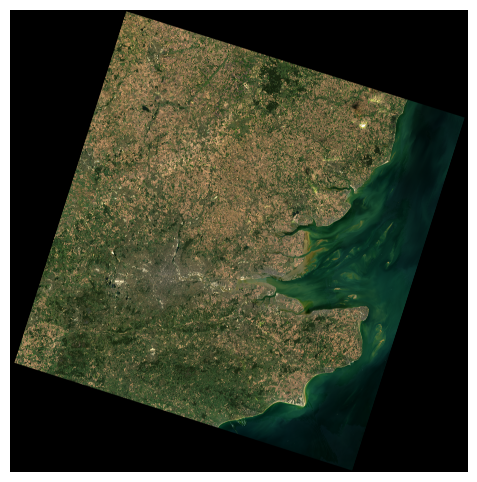

In [120]:
# Surface reflectance (SR)

# BANDS: Blue = B2, Green = B3, and Red = B4

# Load bands
Blue = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B2.TIF')
Green = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B3.TIF')
Red = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B4.TIF')

# Stack and scale bands
# dstack stacks arrays along third dimension (i.e. (n,m) becomes (n,m,1), then bands stacked)
RGB = np.dstack((Red, Green, Blue))

# clip sets takes array (first element) and sets min and max values (2nd and 3rd elements)
RGB = np.clip(RGB*0.0000275-0.2, 0, 1)
RGB = np.clip(RGB,0,0.2)/0.2 # Clip to enhance contrast

# Display RGB image
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(RGB)
ax.set_axis_off()

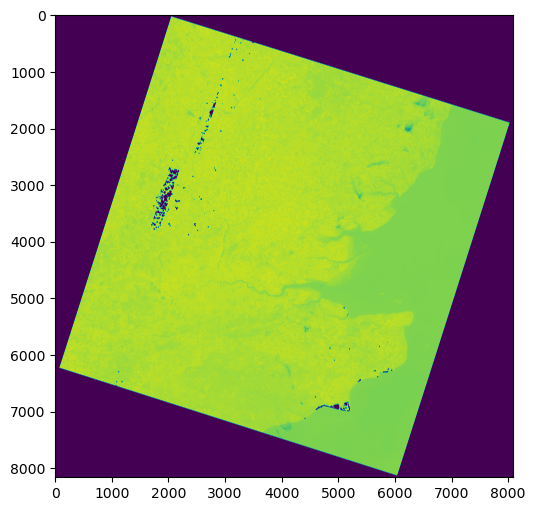

In [121]:
# Surface temperature (ST) is band B10.TIF
ST = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF')
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(ST)
#ax.set_axis_off()

## 2. Convert CRS
Landsat uses UTM coordinate reference system (crs), whereas London data uses bng or lat-longs.

Lat-longs are WGS-84 crs aka EPSG 4326, BNG are EPSG 27700.

Landsat uses the EPSG:32631 crs


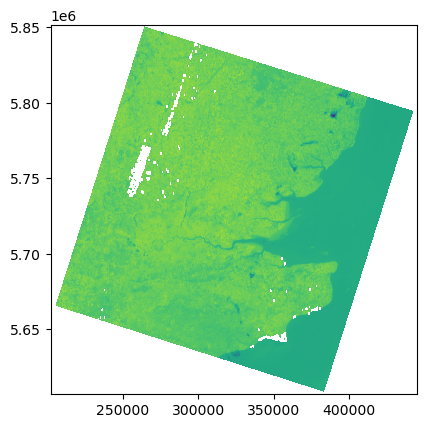

In [109]:
# First get landsat's crs
with rio.open(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF') as src:
    landsat_crs = src.crs
    print(f'Landsat uses the {landsat_crs} crs')
    show(src)

In [115]:
def convert_crs(output_crs, output_filename):
    
    output_raster_path = f'./data/intermediate/{output_filename}.tif'

    # Open the input raster file
    with rio.open(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF') as src:
        # Get the transform and dimensions for the reprojected raster
        transform, width, height = calculate_default_transform(
            src.crs, output_crs, src.width, src.height, *src.bounds)

        # Set up the reprojected dataset
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': output_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the output raster file with EPSG:4326
        with rio.open(output_raster_path, 'w', **kwargs) as dst:
            # Reproject the data from the source CRS to the target CRS
            reproject(
                source=rio.band(src, 1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=output_crs,
                resampling=Resampling.nearest)

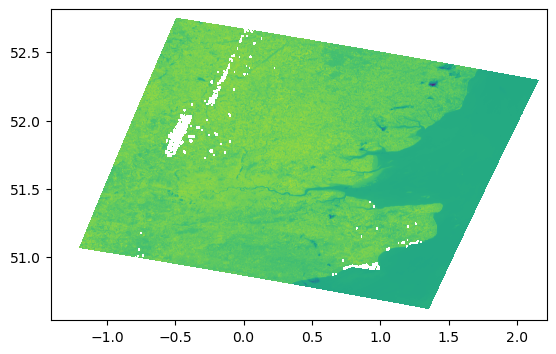

In [117]:
convert_crs(output_crs = 'EPSG:4326', output_filename = 'B10_lat_longs')
with rio.open('./data/intermediate/B10_lat_longs.tif') as src:
    show(src)

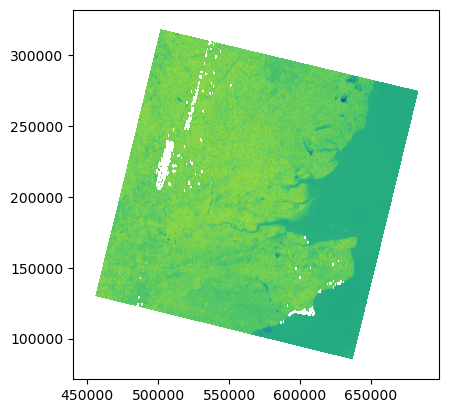

In [119]:
convert_crs(output_crs = 'EPSG:27700', output_filename = 'B10_bng')
with rio.open('./data/intermediate/B10_bng.tif') as src:
    show(src)

## 3. Crop Image to London Shapefile

### 3A. Prepare London shapefile
Crop England LSOA shapefile based on London LSOA list

In [2]:
from rasterio import mask
import geopandas as gpd

# Path to the shapefile containing the irregular polygon for London
london_boroughs_path = './data/raw/london_gis_boundaries/London_Borough_Excluding_MHW.shp'
london_boroughs = gpd.read_file(london_boroughs_path)

london_boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [4]:
# Path to the shapefile containing the polygon for London
england_lsoas_path = './data/raw/england_lsoa_shapefiles/LSOA_2021_EW_BFC_V8.shp'
england_lsoas = gpd.read_file(england_lsoas_path)

england_lsoas.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,ba0bf04c-03e6-4748-acf5-9dd1219c1860,"POLYGON ((532151.537 181867.433, 532152.500 18..."
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,f4b205a5-5f68-4161-a014-5a2f51681597,"POLYGON ((532634.497 181926.016, 532632.048 18..."
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,76c0a1fd-e446-4c40-9d5d-c98d689f23d5,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,13d65a8b-5e13-443a-b355-5775794de964,"POLYGON ((533619.062 181402.364, 533639.868 18..."
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,06953962-0ae1-417a-8357-b314a1fb5716,"POLYGON ((545126.852 184310.838, 545145.213 18..."


In [25]:
lsoa_lookup = pd.read_csv('./data/raw/london_gis_boundaries/area_lookup.csv')

lsoa_lookup = lsoa_lookup[['LSOA21CD', 'LEP21NM1']]
lsoa_list = lsoa_lookup[lsoa_lookup['LEP21NM1'] == 'London']
lsoa_list = lsoa_list.drop_duplicates()
lsoa_list

/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_917/1118134014.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_lookup = pd.read_csv('./data/london_gis_boundaries/area_lookup.csv')


,LSOA21CD,LEP21NM1
152051,E01000020,London
152052,E01000022,London
152053,E01034471,London
152054,E01000024,London
152055,E01000025,London
...,...,...
178508,E01004757,London
178562,E01004751,London
178581,E01032513,London
178586,E01004760,London


In [26]:
london_lsoas_bng = pd.merge(england_lsoas, lsoa_list, on='LSOA21CD', how='left')

# Filter rows where 'LEP' is 'London'
london_lsoas_bng = london_lsoas_bng[london_lsoas_bng['LEP21NM1'] == 'London']

In [27]:
london_lsoas_bng

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,LEP21NM1
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,ba0bf04c-03e6-4748-acf5-9dd1219c1860,"POLYGON ((532151.537 181867.433, 532152.500 18...",London
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,f4b205a5-5f68-4161-a014-5a2f51681597,"POLYGON ((532634.497 181926.016, 532632.048 18...",London
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,76c0a1fd-e446-4c40-9d5d-c98d689f23d5,"POLYGON ((532153.703 182165.155, 532158.250 18...",London
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,13d65a8b-5e13-443a-b355-5775794de964,"POLYGON ((533619.062 181402.364, 533639.868 18...",London
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,06953962-0ae1-417a-8357-b314a1fb5716,"POLYGON ((545126.852 184310.838, 545145.213 18...",London
...,...,...,...,...,...,...,...,...,...
33711,E01035718,Westminster 019G,527211,180107,-0.168450,51.5056,8baf352e-3ca0-4b11-904d-52289e99b369,"POLYGON ((528044.949 180617.984, 528046.344 18...",London
33712,E01035719,Westminster 021F,530127,178755,-0.126950,51.4928,90477cd0-53bb-4c95-a13c-32b112c32bab,"POLYGON ((530267.000 178811.300, 530265.750 17...",London
33713,E01035720,Westminster 021G,530009,178440,-0.128770,51.4900,279a5102-90bf-4922-a543-e81e03303727,"POLYGON ((529856.151 178761.747, 529856.859 17...",London
33714,E01035721,Westminster 023H,528403,178364,-0.151920,51.4897,c35ae6f9-db18-4703-a8c2-d23ba68284df,"POLYGON ((528641.815 178630.886, 528635.688 17...",London


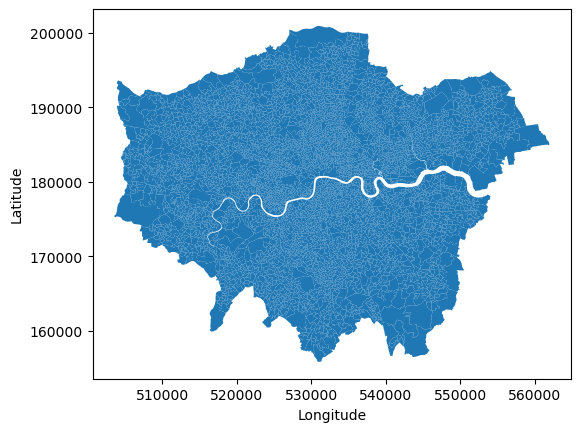

In [28]:
fig, ax = plt.subplots()
london_lsoas_bng.geometry.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### 2B. Converting London CRS to Lat Longs (wgs84) 
London lsoa polygons have BNG coordintes which we convert to wgs84 lat longs.

In [29]:
# Define the Coordinate Reference Systems (CRS):
# Specify the CRS for BNG (British National Grid) and the target CRS for latitude and longitude. BNG commonly uses EPSG code 27700, and WGS84 (lat/lon) uses EPSG code 4326.

# BNG CRS
bng_crs = london_lsoas_bng.crs

# WGS84 is the standard lat-long CRS. 4326 specifically refers to the WGS84 CRS.
wgs84_crs = {'init': 'epsg:4326'}

# Transform Coordinates:
#Use Pyproj to transform the geometries from BNG to WGS84.

from pyproj import Proj, transform

# Define the transformation function
project_bng = Proj(init=bng_crs)
project_wgs84 = Proj(wgs84_crs)

/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
# Takes 10mins to run for london_lsoas
from shapely.geometry import Point, MultiPoint
from shapely.geometry import Polygon, MultiPolygon

# Apply the transformation to each geometry
def transform_coordinates(geometry):
    if geometry.geom_type == 'Polygon':
        exterior_coords = list(zip(*transform(project_bng, project_wgs84, *geometry.exterior.xy)))
        exterior = Polygon(exterior_coords)

        interior = []
        for interior_ring in geometry.interiors:
            interior_coords = list(zip(*transform(project_bng, project_wgs84, *interior_ring.xy)))
            interior.append(interior_coords)

        return Polygon(exterior.exterior.coords, interior)

    elif geometry.geom_type == 'MultiPolygon':
        return MultiPolygon([transform_coordinates(polygon) for polygon in geometry.geoms])

    else:
        return geometry

#london_lsoas2['geometry'] = london_lsoas2['geometry'].apply(lambda geom: transform_coordinates(geom))
london_lsoas['geometry'] = london_lsoas_bng['geometry'].apply(transform_coordinates)

london_lsoas.head()

/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_917/3522270130.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  exterior_coords = list(zip(*transform(project_bng, project_wgs84, *geometry.exterior.xy)))
/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_917/3522270130.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  interior_coords = list(zip(*transform(project_bng, project_wgs84, *interior_ring.xy)))


,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,LEP21NM1
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,ba0bf04c-03e6-4748-acf5-9dd1219c1860,"POLYGON ((-0.097 51.520, -0.097 51.520, -0.097...",London
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,f4b205a5-5f68-4161-a014-5a2f51681597,"POLYGON ((-0.090 51.521, -0.090 51.521, -0.090...",London
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,76c0a1fd-e446-4c40-9d5d-c98d689f23d5,"POLYGON ((-0.097 51.523, -0.096 51.523, -0.096...",London
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,13d65a8b-5e13-443a-b355-5775794de964,"POLYGON ((-0.076 51.516, -0.075 51.516, -0.075...",London
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,06953962-0ae1-417a-8357-b314a1fb5716,"POLYGON ((0.091 51.539, 0.091 51.539, 0.091 51...",London


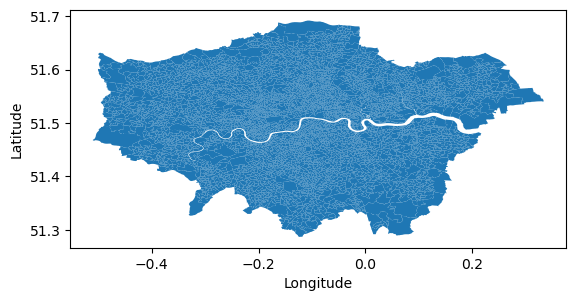

In [31]:
fig, ax = plt.subplots()
london_lsoas.geometry.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
# Save London lsoa shapefile
london_lsoas.to_file('./data/intermediate/london_lsoa_lat_long.shp', driver='ESRI Shapefile')

### 2C. UTM to wgs84 converter

Based on the file *LC09_L2SP_201024_20230907_20230913_02_T1_MTL.txt*, the UTM coordinates of the corners are:
- CORNER_UL_PROJECTION_X_PRODUCT = 202200.000 
- CORNER_UL_PROJECTION_Y_PRODUCT = 5851800.000
- CORNER_UR_PROJECTION_X_PRODUCT = 444600.000
- CORNER_UR_PROJECTION_Y_PRODUCT = 5851800.000
- CORNER_LL_PROJECTION_X_PRODUCT = 202200.000
- CORNER_LL_PROJECTION_Y_PRODUCT = 5607000.000
- CORNER_LR_PROJECTION_X_PRODUCT = 444600.000
- CORNER_LR_PROJECTION_Y_PRODUCT = 5607000.000

In [39]:
# Check what crs it uses
es.crs_check(all_landsat_post_bands[0])

NameError: name 'all_landsat_post_bands' is not defined

In [4]:
from pyproj import Proj, transform

# Define London UTM zone and coordinates
utm_zone = 31
# utm_easting = 324600 
# utm_northing = 5710158

# Function to convert UTM coordinates to BNG coordinates
def utm_to_bng(utm_easting, utm_northing, utm_zone):
    
    # Step 1: Convert UTM to Geographic Coordinates
    utm_projection = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
    lon, lat = utm_projection(utm_easting, utm_northing, inverse=True)

    # Step 2: Transform to OSGB36 Datum (osgb = ordance survey GB)
    wgs84_proj = Proj(init='epsg:4326')  # WGS84
    osgb36_proj = Proj(init='epsg:27700')  # OSGB36

    lon_osgb36, lat_osgb36 = transform(wgs84_proj, osgb36_proj, lon, lat)

    # Step 3: Convert to Ordnance Survey National Grid Coordinates
    osgb36_easting, osgb36_northing = transform(osgb36_proj, osgb36_proj, lon_osgb36, lat_osgb36)

    return osgb36_easting, osgb36_northing

In [36]:
utm_to_bng(699319, 5710158, 30)

/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_90755/1980388193.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-py

(530031.4329727577, 180374.3003483013)

In [17]:
# Example using a rasterio object
output_raster_path = f"./data/{pane_id}/ST_bng.tif"

# Open the raster file
with rio.open(f'./data/{pane_id}/{pane_id}_ST_B10.TIF') as src:
    
    # Get UTM coordinates of the center of the raster
    #utm_easting, utm_northing = src.xy(src.width // 2, src.height // 2)
    
    # coords of origin (top left)
    utm_easting, utm_northing = src.xy(0,0)

    # Get UTM zone from the raster's CRS
    utm_zone = 31

    # Convert UTM to BNG coordinates
    bng_easting, bng_northing = utm_to_bng(utm_easting, utm_northing, utm_zone)

    # Update the raster's transform to use BNG coordinates
    new_transform = rio.transform.from_origin(bng_easting, bng_northing, src.transform.a, src.transform.e)
    
    # Write the output raster with BNG coordinates
    with rio.open(output_raster_path, 'w', driver='GTiff', height=src.height, width=src.width,
                       count=src.count, dtype=src.dtypes[0], crs=src.crs, transform=new_transform) as dst:
        for i in range(1, src.count + 1):
            dst.write(src.read(i), i)

/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Sim/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_90755/1980388193.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-py

In [20]:
utm_easting, utm_northing

(202200.0, 5851800.0)

In [18]:
bng_easting, bng_northing

(439830.96457418235, 315301.0540695317)

In [19]:
with rio.open(f'./data/{pane_id}/ST_bng.TIF') as src:
    bounds = src.bounds
    print("Bounds:", bounds)
    crs = src.crs
    print("Coordinate Reference System:", crs)

with rio.open(f'./data/{pane_id}/{pane_id}_ST_B10.TIF') as src:
    bounds = src.bounds
    print("Bounds:", bounds)
    crs = src.crs
    print("Coordinate Reference System:", crs)

Bounds: BoundingBox(left=439830.96457418235, bottom=560131.0540695316, right=682260.9645741824, top=315301.0540695317)
Coordinate Reference System: EPSG:32631
Bounds: BoundingBox(left=202185.0, bottom=5606985.0, right=444615.0, top=5851815.0)
Coordinate Reference System: EPSG:32631


In [23]:
raster_path = f'./data/{pane_id}/{pane_id}_ST_B10.TIF'
raster = rio.open(raster_path)
shapefile = london_polygon.geometry

print("Raster CRS:", raster.crs)
print("Shapefile CRS:", shapefile.crs)

Raster CRS: EPSG:32631
Shapefile CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### 2D. Crop the raster file

In [24]:
# Open the raster file
with rio.open(output_raster_path) as src:
    
    # Mask the raster using the polygon geometry
    out_image, out_transform = mask.mask(src, london_polygon.geometry, crop=True)

    # Update the metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

# Specify the path for the cropped raster file
output_path = 'path_to_output_cropped_raster.tif'

# Write the cropped raster to the specified output path
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

ValueError: Input shapes do not overlap raster.

In [152]:
subset.shape

(2000, 1800)

In [52]:
# Using the arrays max/min coordinates, create a coordinate map df 
# top left is coordinate (lat,long) with value (x,y). Bottom right is coord ... with values (x,y)
# Can work out a formula to convert lat = lat_min + 1.5x
# Get df of lat, long, x, y

# corner_upper_left_latitude etc represent coords of blank parts 

# Create long df
st_df = pd.DataFrame(ST)
st_df['y'] = range(0, len(st_df))
st_df = pd.melt(st_df, id_vars=['y'], var_name='x', value_name='value')


#pane_meta_data['corner_upper_left_latitude']
# Pull in London shapefile to filter to London by coordinate?  
# Filter the array to be London coordinates

,y,x,value
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
65949036,8156,8080,0
65949037,8157,8080,0
65949038,8158,8080,0
65949039,8159,8080,0
